<a href="https://colab.research.google.com/github/moonjune/test-repo/blob/master/knlp_rnnkind_prac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#참고:  lambfish https://github.com/bluelight773/Kaggle_IMDB_Bags_of_Popcorn/blob/master/imdb.py.
from google.colab import files
files.upload()

In [2]:
import os
os.chdir('/content')
!ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!mkdir -p /content/kaggle_bag_of_word
os.chdir('/content/kaggle_bag_of_word')
!kaggle competitions download -c word2vec-nlp-tutorial

  0% 0.00/276k [00:00<?, ?B/s]
100% 276k/276k [00:00<00:00, 41.9MB/s]
 35% 9.00M/26.0M [00:00<00:00, 67.8MB/s]
100% 26.0M/26.0M [00:00<00:00, 102MB/s] 
 71% 9.00M/12.6M [00:00<00:00, 82.0MB/s]
100% 12.6M/12.6M [00:00<00:00, 80.8MB/s]
 69% 9.00M/13.0M [00:00<00:00, 56.0MB/s]
100% 13.0M/13.0M [00:00<00:00, 63.3MB/s]


In [0]:
import zipfile

DATA_IN_PATH = '/content/kaggle_bag_of_word/'

file_list = ['labeledTrainData.tsv.zip','unlabeledTrainData.tsv.zip', 'testData.tsv.zip']

for file in file_list:
  zipRef = zipfile.ZipFile(DATA_IN_PATH + file, 'r')
  zipRef.extractall(DATA_IN_PATH)
  zipRef.close()
             

In [7]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from bs4 import BeautifulSoup
import pickle
import os, re
print(os.listdir("/content/kaggle_bag_of_word/"))
from nltk.corpus import stopwords

# Any results you write to the current directory are saved as output.

['unlabeledTrainData.tsv.zip', 'testData.tsv', 'unlabeledTrainData.tsv', 'sampleSubmission.csv', 'testData.tsv.zip', 'labeledTrainData.tsv', 'labeledTrainData.tsv.zip']


In [0]:
train = pd.read_csv("/content/kaggle_bag_of_word/labeledTrainData.tsv", header = 0, delimiter = '\t') # 훈련용 데이터(id, review, sentiment, (25000,3))
test = pd.read_csv("/content/kaggle_bag_of_word/testData.tsv", header = 0, delimiter = '\t') # 테스트용 데이터(id, review, sentiment, (25000,3))

In [43]:
test['review'][0:10]

0    Naturally in a film who's main themes are of m...
1    This movie is a disaster within a disaster fil...
2    All in all, this is a movie for kids. We saw i...
3    Afraid of the Dark left me with the impression...
4    A very accurate depiction of small time mob li...
5    ...as valuable as King Tut's tomb! (OK, maybe ...
6    This has to be one of the biggest misfires eve...
7    This is one of those movies I watched, and won...
8    The worst movie i've seen in years (and i've s...
9    Five medical students (Kevin Bacon, David Labr...
Name: review, dtype: object

In [0]:
test["sentiment"] = test["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0) #??? 뒷자리가 5 이상이면 1, 아니면 0으로 하라는데 뭔가 맞네???
y_test = test["sentiment"] # 얘는 판다스 Series

In [40]:
print(type(y_test), y_test.dtype, y_test.shape)

<class 'pandas.core.series.Series'> int64 (25000,)


In [0]:
def html_to_text(review):
    """Return extracted text string from provided HTML string."""
    review_text = BeautifulSoup(review, "lxml").get_text()     # html 텍스트들 정제함. review는 문자열임, loop 되는 애들이 아님
    if len(review_text) == 0:
        review_text = review
    review_text = re.sub(r"\<.*\>", "", review_text) # 기타 특수문자를 없애버림
    try:
        review_text = review_text.encode('ascii', 'ignore').decode('ascii')#ignore \xc3 etc. 
    except UnicodeDecodeError:
        review_text = review_text.decode("ascii", "ignore")
    return review_text # 리뷰 텍스트는 특수문자 없는 문장으로 나옴(유니코드 문제에 대해 대응)


def letters_only(text):
    """Return input string with only letters (no punctuation, no numbers)."""
    # It is probably worth experimenting with milder prepreocessing (eg just removing punctuation)
    return re.sub("[^a-zA-Z]", " ", text) # 숫자 기호 다 없애 줌 알파벳이 아닌건 몽땅 삭제

def rnn_tokenizer_review_preprocess(review):
    """Preprocessing used before fitting/transforming RNN tokenizer - Html->text, remove punctuation/#s, lowercase."""
    return letters_only(html_to_text(review)).lower() 
  # rnn 뭐시뭐시 하지만 그냥 기호 떼기임. 위에서 HTML기호를 없애기 데려오고 거기서 알파벳만 남기기 데려오고, 그걸 소문자화하는 함수...

In [0]:
def get_train_val_data(reviews_to_features_fn=None, df = train):
    """Extracts features (using reviews_to_features_fn), splits into train/test data, and returns
    x_train, y_train, x_test, y_test.  If no feature extraction function is provided, x_train/x_test will
    simply consist of a Series of all the reviews.
    """
#     df = pd.read_csv('labeledTrainData.tsv', header=0, quotechar='"', sep='\t')
    SEED = 1000
    # Shuffle data frame rows
    np.random.seed(SEED)
    df = df.iloc[np.random.permutation(len(df))]

    if reviews_to_features_fn:
        feature_rows = df["review"].map(reviews_to_features_fn)
        if type(feature_rows[0]) == np.ndarray:
            num_instances = len(feature_rows)
            num_features = len(feature_rows[0])
            x = np.concatenate(feature_rows.values).reshape((num_instances, num_features))
        else:
            x = feature_rows
    else:
        x = df["review"]

    y = df["sentiment"]

    # Split 80/20
    test_start_index = int(df.shape[0] * .8)
    x_train = x[0:test_start_index]
    y_train = y[0:test_start_index]
    x_val = x[test_start_index:]
    y_val = y[test_start_index:]

    return x_train, y_train, x_val, y_val

In [0]:
x_train, y_train, x_val, y_val = get_train_val_data(rnn_tokenizer_review_preprocess)
x_test = test["review"].map(rnn_tokenizer_review_preprocess)
y_test = test["sentiment"]

In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


In [0]:
np.random.seed(1000)
num_most_freq_words_to_include = 5000
MAX_REVIEW_LENGTH_FOR_KERAS_RNN = 500
embedding_vector_length = 32

In [0]:
# train_review_list = [s.encode('ascii') for s in x_train.tolist()]
# val_review_list = [s.encode('ascii') for s in x_val.tolist()]
# all_review_list = train_review_list + val_review_list
train_review_list = x_train.tolist()
val_review_list = x_val.tolist()
test_review_list = x_test.tolist()
all_review_list = x_train.tolist() + x_val.tolist()

In [0]:
tokenizer = Tokenizer(num_words=num_most_freq_words_to_include)
tokenizer.fit_on_texts(all_review_list)

In [0]:
train_reviews_tokenized = tokenizer.texts_to_sequences(train_review_list)
x_train = pad_sequences(train_reviews_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
val_review_tokenized = tokenizer.texts_to_sequences(val_review_list)
x_val = pad_sequences(val_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
test_review_tokenized = tokenizer.texts_to_sequences(test_review_list)
x_test = pad_sequences(test_review_tokenized, maxlen=MAX_REVIEW_LENGTH_FOR_KERAS_RNN)

In [0]:
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPool1D, GRU, LSTM, Dense
from keras.models import Model

In [0]:
def rnn_model(use_cnn = True, use_lstm = False):
    input_sequences = Input(shape = (MAX_REVIEW_LENGTH_FOR_KERAS_RNN,))
    initial_dropout = 0.2
    embedding_layer = Embedding(input_dim = num_most_freq_words_to_include, 
                                output_dim = embedding_vector_length,
                                input_length = MAX_REVIEW_LENGTH_FOR_KERAS_RNN)
    X = embedding_layer(input_sequences)
    X = Dropout(0.2)(X)
    if use_cnn:
        X = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(X)
        X = MaxPool1D(pool_size=2)(X)
        
    # Add GRU layers
    dropout_W = 0.0
    dropout_U = 0.0
    
    if use_lstm:
        X = LSTM(100, dropout = dropout_W, recurrent_dropout = dropout_U)(X)
    else:
        X = GRU(100, dropout=dropout_W, recurrent_dropout=dropout_U)(X)
    X = Dropout(0.2)(X)
    outputs= Dense(1, activation='sigmoid')(X)
    model = Model(inputs = input_sequences, outputs = outputs)
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [21]:
gru_model = rnn_model(use_lstm=False)

W0624 05:20:25.208293 139747224688512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 05:20:25.261114 139747224688512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 05:20:25.269737 139747224688512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 05:20:25.289781 139747224688512 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 05:20:25.300491 

In [22]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 100)               39900     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
__________

In [23]:
gru_model.fit(x_train, y_train, batch_size=64, epochs=3, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 105s 5ms/step - loss: 0.4858 - acc: 0.7387 - val_loss: 0.3553 - val_acc: 0.8464
Epoch 2/3
20000/20000 [==============================] - 104s 5ms/step - loss: 0.2961 - acc: 0.8778 - val_loss: 0.3117 - val_acc: 0.8776
Epoch 3/3
20000/20000 [==============================] - 104s 5ms/step - loss: 0.2130 - acc: 0.9187 - val_loss: 0.3048 - val_acc: 0.8796


In [0]:
y_test_pred_gru = gru_model.predict(x_test)

In [25]:
lstm_model = rnn_model(use_lstm=True)
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 500)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
__________

In [26]:
lstm_model.fit(x_train, y_train, batch_size = 64, epochs = 3, validation_data=[x_val, y_val])

Train on 20000 samples, validate on 5000 samples
Epoch 1/3
20000/20000 [==============================] - 127s 6ms/step - loss: 0.5048 - acc: 0.7458 - val_loss: 0.3065 - val_acc: 0.8740
Epoch 2/3
20000/20000 [==============================] - 127s 6ms/step - loss: 0.2682 - acc: 0.8931 - val_loss: 0.3084 - val_acc: 0.8740
Epoch 3/3
20000/20000 [==============================] - 127s 6ms/step - loss: 0.2238 - acc: 0.9141 - val_loss: 0.3009 - val_acc: 0.8822


In [0]:
y_test_pred_lstm = lstm_model.predict(x_test)

In [0]:
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
print("The AUC socre for GRU model is : %.4f." %roc_auc_score(y_test, y_test_pred_gru))
print("The AUC socre for LSTM model is : %.4f." %roc_auc_score(y_test, y_test_pred_lstm))

The AUC socre for GRU model is : 0.9485.
The AUC socre for LSTM model is : 0.9463.


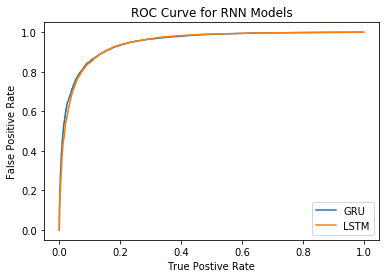

In [30]:
y_pred_list = [y_test_pred_gru, y_test_pred_lstm]
label_list = ["GRU", "LSTM"]
pred_label = zip(y_pred_list, label_list)
for y_pred, lbl in pred_label:
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr, label = lbl)

plt.xlabel("True Postive Rate")
plt.ylabel("False Positive Rate")
plt.title("ROC Curve for RNN Models")
plt.legend()
plt.show()